In [193]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import struct
from collections import OrderedDict
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap

In [210]:
def read_data(num, path):
    data = np.zeros((num,32,32),dtype=np.float64)
    for idx in range(0, num):
        data[idx][:][:] = cv2.imread(path + str(idx) + '.png', 0)

    data = data.reshape(num,32*32)
    return data

def create_label(num):
    Carambula_label = np.zeros(num) #label:0
    Lychee_label = np.ones(num) #label:1
    Pear_label = np.ones(num)*2 #label:2
    tmp = np.concatenate((Carambula_label, Lychee_label))
    label = np.concatenate((tmp, Pear_label))
    return label

def one_hot(labels, num_classes=3):
    label_one_hot = np.zeros((num_classes, labels.shape[0])) #put in 0
    for i in range(labels.shape[0]):
        label_one_hot[int(labels[i]), i] = 1 #put in 1
    return label_one_hot.T

def PCA_func(train_data, test_data):
    total_data = np.concatenate(((train_data, test_data)),axis=0) #1-dim
    pca = PCA(n_components=2)
    total_data = pca.fit(total_data) #train model

    train_PCA_data = pca.transform(train_data)
    test_PCA_data = pca.transform(test_data)
    return train_PCA_data, test_PCA_data

def print_pca(data,label):
    pca = PCA(n_components=2)
    markers = ['.', '.', '.']
    colors = ('red', 'blue', 'orange')
    classes = ['Carambula', 'Lychee', 'Pear']
    labels = [0., 1., 2.]  
    x_2D = pca.fit(data).transform(data)

    for c, i, target_name, m in zip(colors, labels, classes, markers):
        plt.scatter(x_2D[label == i, 0], x_2D[label == i, 1], c=c, label=target_name, marker=m)

    plt.xlabel('PCA-feature-1')
    plt.ylabel('PCA-feature-2')
    plt.legend(classes, loc='upper right')
    

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True) #avoid overflow 
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)

    batch_size = y.shape[0]
    return -np.sum(t*np.log(y + 1e-7))/batch_size
    
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        #x<=0:true, x>0:false
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None #loss
        self.y = None #solfmax output
        self.t = None #training data(one-hot)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size 
        return dx


class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


class TwoLayerNet:
    def __init__(self, input_size, hidden_layer, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer = hidden_layer
        self.hidden_layer_num = len(hidden_layer)

        self.params = {}

        # initial weight
        self.init_weight()

        # layers
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            # Affine + layer number
            self.layers['Affine'+ str(idx)] = Affine(self.params['W'+ str(idx)], self.params['b'+ str(idx)])
            # Relu + layer number
            self.layers['Relu'+ str(idx)] = Relu()

        idx = self.hidden_layer_num + 1
        self.layers['Affine'+ str(idx)] = Affine(self.params['W'+ str(idx)], self.params['b'+ str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def init_weight(self):
        total_size = [self.input_size] + self.hidden_layer + [self.output_size]
        #recommend initial
        for idx in range(1, len(total_size)):
            scale = np.sqrt(2.0/total_size[idx-1])

            self.params['W'+ str(idx)] = scale * np.random.randn(total_size[idx-1],total_size[idx])
            self.params['b'+ str(idx)] = np.zeros(total_size[idx])


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y ==t) / float(x.shape[0])
        return accuracy
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
        
        return grads

def plot_decision_regions(X, Y, Y_pred, classifier):
    # X:feature data, Y:label data, Y_pred: 
    X = np.delete(X, 2, axis=1) #delete bias
    Y = np.argmax(Y, axis=1)
    Y_pred = np.argmax(Y_pred, axis=1)

    resolution = 0.01

    markers = ('.', '.', '.')
    colors = ('red', 'blue', 'orange')
    cmap = ListedColormap(colors[:len(np.unique(Y_pred))])

    # decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # coordinate matrix
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))  
    bias = np.ones((xx1.size, 1))
    
    input_data = np.c_[xx1.ravel(), xx2.ravel(), bias]
    Z = classifier.predict(input_data)
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx1.shape) 


    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap) #contour plot
    plt.xlim(xx1.min(), xx1.max()) #limit x-axis
    plt.ylim(xx2.min(), xx2.max()) #limit y-axis

    # plot
    for idx, cl in enumerate(np.unique(Y_pred)):
        plt.scatter(x=X[Y == cl, 0], y=X[Y == cl, 1], alpha=0.6, c=[cmap(idx)], marker=markers[idx], label=cl)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='lower left')



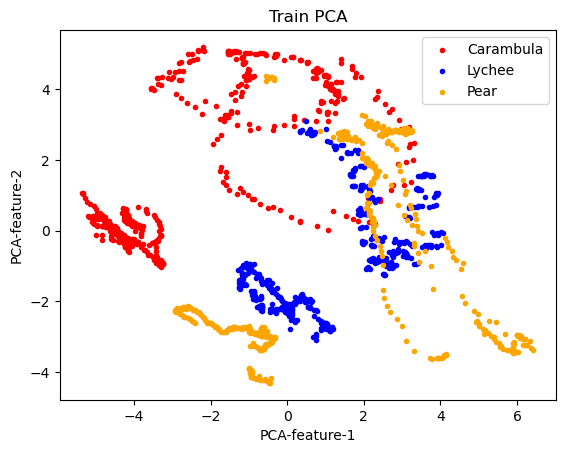

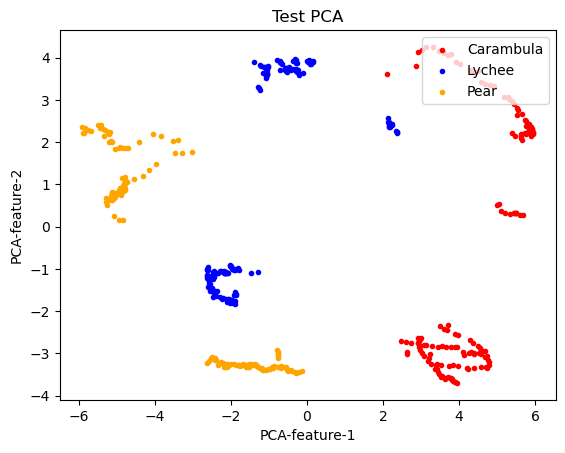

In [211]:
# ======== main ======== #
train_num = 490
test_num = 166

## read data
train_Carambula = read_data(train_num, './Data_train/Carambula/Carambula_train_')
train_Lychee = read_data(train_num, './Data_train/Lychee/Lychee_train_')
train_Pear = read_data(train_num, './Data_train/Pear/Pear_train_')
tmp = np.concatenate((train_Carambula ,train_Lychee))
train_data = np.concatenate((tmp, train_Pear))

test_Carambula = read_data(test_num, './Data_test/Carambula/Carambula_test_')
test_Lychee = read_data(test_num, './Data_test/Lychee/Lychee_test_')
test_Pear = read_data(test_num, './Data_test/Pear/Pear_test_')
tmp = np.concatenate((test_Carambula ,test_Lychee))
test_data = np.concatenate((tmp, test_Pear))

## normalize
train_data = train_data/255
test_data = test_data/255

## PCA
train_PCA_data, test_PCA_data = PCA_func(np.array(train_data)[:,1:], np.array(test_data)[:,1:])
train_data = np.array(train_PCA_data)
test_data = np.array(test_PCA_data)

## label
train_label = create_label(train_num)
test_label = create_label(test_num)

# print train PCA
print_pca(train_data,train_label)
plt.title('Train PCA')
plt.show()
print_pca(test_data,test_label)
plt.title('Test PCA')
plt.show()

# label to one-hot
train_label = one_hot(train_label)
test_label = one_hot(test_label)

# add bias
train_bias = np.ones(train_num*3).reshape(train_num*3,1)
train_data = np.concatenate((train_data, train_bias),axis=1)

test_bias = np.ones(test_num*3).reshape(test_num*3,1)
test_data = np.concatenate((test_data, test_bias),axis=1)

Epoch:1/100, test accuracy: 0.478 
Epoch:2/100, test accuracy: 0.641 
Epoch:3/100, test accuracy: 0.721 
Epoch:4/100, test accuracy: 0.671 
Epoch:5/100, test accuracy: 0.906 
Epoch:6/100, test accuracy: 0.867 
Epoch:7/100, test accuracy: 0.697 
Epoch:8/100, test accuracy: 0.837 
Epoch:9/100, test accuracy: 0.865 
Epoch:10/100, test accuracy: 0.821 
Epoch:11/100, test accuracy: 0.894 
Epoch:12/100, test accuracy: 0.821 
Epoch:13/100, test accuracy: 0.837 
Epoch:14/100, test accuracy: 0.833 
Epoch:15/100, test accuracy: 0.861 
Epoch:16/100, test accuracy: 0.865 
Epoch:17/100, test accuracy: 0.865 
Epoch:18/100, test accuracy: 0.839 
Epoch:19/100, test accuracy: 0.825 
Epoch:20/100, test accuracy: 0.861 
Epoch:21/100, test accuracy: 0.871 
Epoch:22/100, test accuracy: 0.845 
Epoch:23/100, test accuracy: 0.878 
Epoch:24/100, test accuracy: 0.839 
Epoch:25/100, test accuracy: 0.839 
Epoch:26/100, test accuracy: 0.833 
Epoch:27/100, test accuracy: 0.833 
Epoch:28/100, test accuracy: 0.833 
E

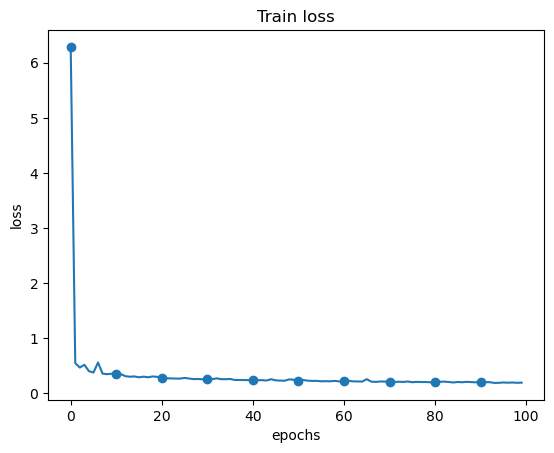

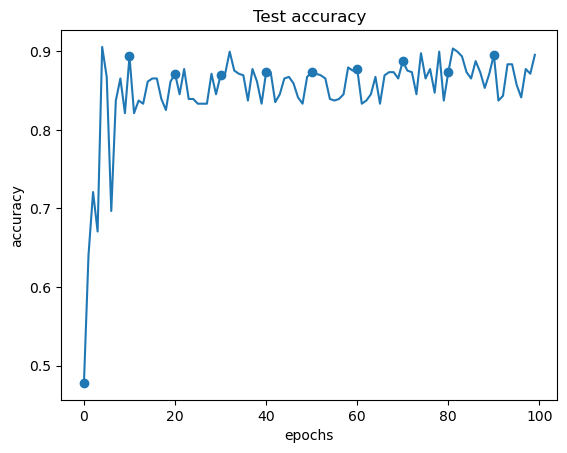

In [197]:
## two layers neural network

#===hyperparameters===
epoch = 100
batch_size = 200
lr = 0.1
iter = 10000000
#=====================

network = TwoLayerNet(input_size=3, hidden_layer=[100,50], output_size=3)
optimizer = SGD(lr)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = int(max(train_num*3/batch_size, 1))

epoch_count = 0
for idx in range(iter):
    #mini-batch
    batch_mask = np.random.choice(train_num*3, batch_size) #pick random
    train_data_batch = train_data[batch_mask]
    train_label_batch = train_label[batch_mask]

    #gradient
    grads = network.gradient(train_data_batch, train_label_batch)

    #update paarameters
    optimizer.update(network.params, grads)
    
    #print accuracy
    if idx % iter_per_epoch == 0:
        train_acc = network.accuracy(train_data, train_label)
        train_loss = network.loss(train_data, train_label)
        train_predict = network.predict(train_data)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        test_acc = network.accuracy(test_data, test_label)
        test_acc_list.append(test_acc)
        test_predict = network.predict(test_data)

        print("Epoch:"+ str(epoch_count+1) + "/" + str(epoch)+ ", test accuracy: {0:0.3f} ".format(test_acc))

        epoch_count += 1
        if epoch_count == epoch:
            break

# plot loss
markers = {'training loss:': 'o'}
x = np.arange(epoch)
plt.plot(x, train_loss_list, marker='o', label='training loss', markevery=10)
plt.title('Train loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# plot accuracy
markers = {'testing accuracy:': 'o'}
x = np.arange(epoch)
plt.plot(x, test_acc_list, marker='o', label='testing accuracy', markevery=10)
plt.title('Test accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

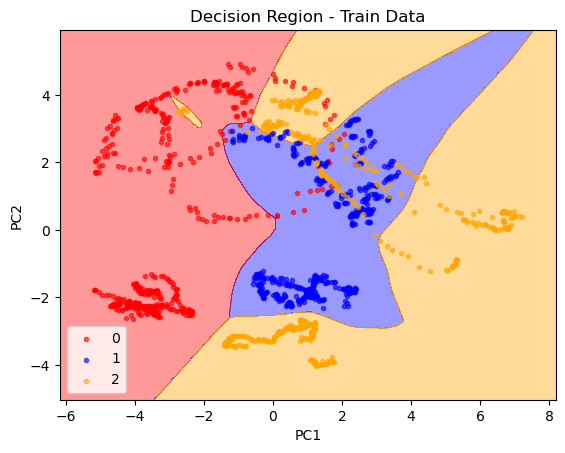

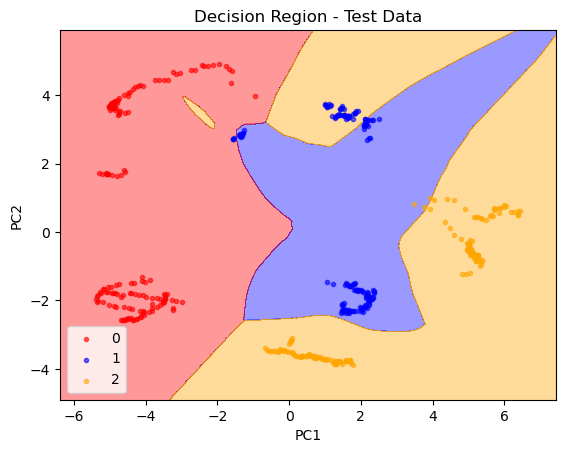

In [198]:
## plot decision regions
#train
plot_decision_regions(train_data, train_label, train_predict, network)
plt.title('Decision Region - Train Data')
plt.show()

#test
plot_decision_regions(test_data, test_label, test_predict, network)
plt.title('Decision Region - Test Data')
plt.show()

Epoch:1/100, test accuracy: 0.333 
Epoch:2/100, test accuracy: 0.741 
Epoch:3/100, test accuracy: 0.781 
Epoch:4/100, test accuracy: 0.673 
Epoch:5/100, test accuracy: 0.829 
Epoch:6/100, test accuracy: 0.819 
Epoch:7/100, test accuracy: 0.789 
Epoch:8/100, test accuracy: 0.873 
Epoch:9/100, test accuracy: 0.878 
Epoch:10/100, test accuracy: 0.869 
Epoch:11/100, test accuracy: 0.878 
Epoch:12/100, test accuracy: 0.878 
Epoch:13/100, test accuracy: 0.932 
Epoch:14/100, test accuracy: 0.880 
Epoch:15/100, test accuracy: 0.878 
Epoch:16/100, test accuracy: 0.847 
Epoch:17/100, test accuracy: 0.880 
Epoch:18/100, test accuracy: 0.839 
Epoch:19/100, test accuracy: 0.869 
Epoch:20/100, test accuracy: 0.880 
Epoch:21/100, test accuracy: 0.869 
Epoch:22/100, test accuracy: 0.880 
Epoch:23/100, test accuracy: 0.869 
Epoch:24/100, test accuracy: 0.880 
Epoch:25/100, test accuracy: 0.871 
Epoch:26/100, test accuracy: 0.839 
Epoch:27/100, test accuracy: 0.873 
Epoch:28/100, test accuracy: 0.876 
E

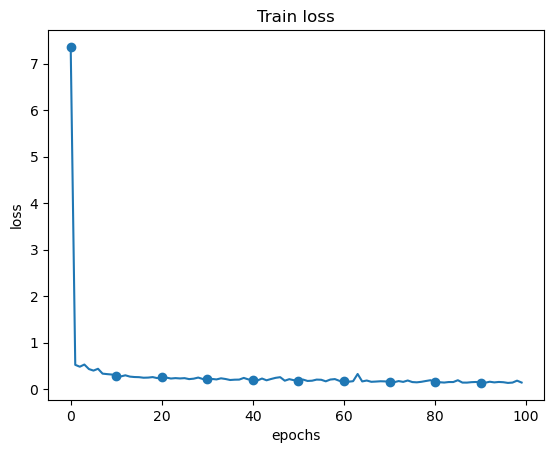

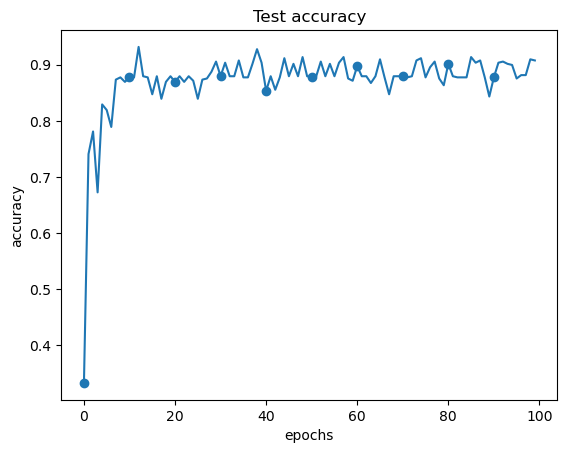

In [205]:
## three layers neural network

#===hyperparameters===
epoch = 100
batch_size = 100
lr = 0.1
iter = 10000000
#=====================

network = TwoLayerNet(input_size=3, hidden_layer=[50,50,50], output_size=3)
optimizer = SGD(lr)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = int(max(train_num*3/batch_size, 1))

epoch_count = 0
for idx in range(iter):
    #mini-batch
    batch_mask = np.random.choice(train_num*3, batch_size) #pick random
    train_data_batch = train_data[batch_mask]
    train_label_batch = train_label[batch_mask]

    #gradient
    grads = network.gradient(train_data_batch, train_label_batch)

    #update paarameters
    optimizer.update(network.params, grads)
    
    #print accuracy
    if idx % iter_per_epoch == 0:
        train_acc = network.accuracy(train_data, train_label)
        train_loss = network.loss(train_data, train_label)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        train_predict = network.predict(train_data)
        
        test_acc = network.accuracy(test_data, test_label)
        test_acc_list.append(test_acc)
        test_predict = network.predict(test_data)

        print("Epoch:"+ str(epoch_count+1) + "/" + str(epoch)+ ", test accuracy: {0:0.3f} ".format(test_acc))

        epoch_count += 1
        if epoch_count == epoch:
            break

# plot loss
markers = {'training loss:': 'o'}
x = np.arange(epoch)
plt.plot(x, train_loss_list, marker='o', label='training loss', markevery=10)
plt.title('Train loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# plot accuracy
markers = {'testing accuracy:': 'o'}
x = np.arange(epoch)
plt.plot(x, test_acc_list, marker='o', label='testing accuracy', markevery=10)
plt.title('Test accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()


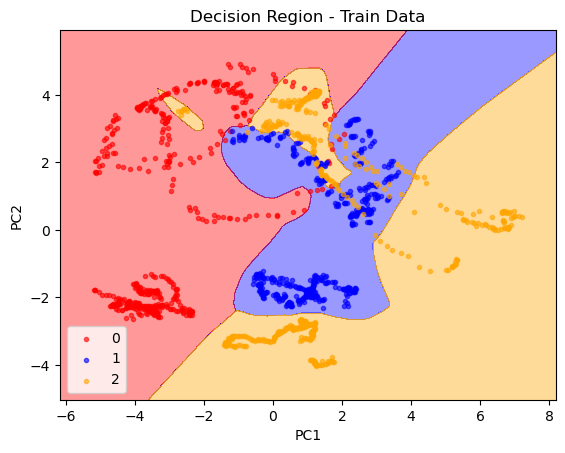

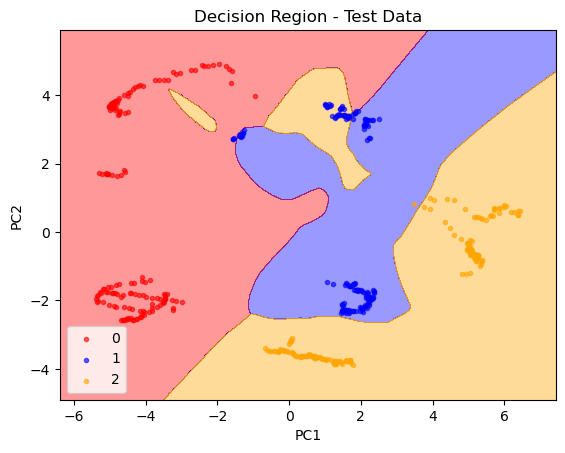

In [206]:
## plot decision regions
#train
plot_decision_regions(train_data, train_label, train_predict, network)
plt.title('Decision Region - Train Data')
plt.show()

#test
plot_decision_regions(test_data, test_label, test_predict, network)
plt.title('Decision Region - Test Data')
plt.show()